In [2]:
import os, sys
import pandas as pd

sys.path.append("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/transformer/")

from grn_inference import utils

from transformer_training import (
    prepare_dataloader,
    
)
import matplotlib.pyplot as plt

TRAINED_MODEL_SAMPLE_NAME = "mESC"
CHROM_ID                  = "chr1"
PROJECT_DIR="/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
OUTPUT_DIR = os.path.join(PROJECT_DIR, "output/transformer_testing_output")
DEV_DIR = os.path.join(PROJECT_DIR, "dev/transformer")
sys.path.append(DEV_DIR)

TRAINED_MODEL_DATASET_DIR = os.path.join(DEV_DIR, f"transformer_data/{TRAINED_MODEL_SAMPLE_NAME}/{CHROM_ID}")
TRAINED_MODEL_DIR         = os.path.join(OUTPUT_DIR, "model_0.77_corr")
COMMON_DATA_DIR           = os.path.join(DEV_DIR, "transformer_data", "common")

DATA_DIR = os.path.join(PROJECT_DIR, "dev/transformer/transformer_data")
GROUND_TRUTH_FILE = os.path.join(PROJECT_DIR, "ground_truth_files/mESC_beeline_ChIP-seq.csv")

In [3]:
gene_near_peaks_df = pd.read_parquet(os.path.join(TRAINED_MODEL_DATASET_DIR, "genes_near_peaks_chr1.parquet"))
training_log_df = pd.read_csv(os.path.join(TRAINED_MODEL_DIR, "training_log.csv"), header=0, index_col=0)

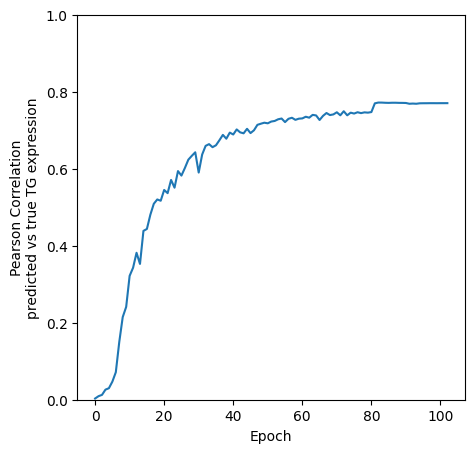

In [4]:
plt.figure(figsize=(5,5))

plt.plot(training_log_df.index, training_log_df["Pearson"])

plt.xlabel("Epoch")
plt.ylabel("Pearson Correlation\npredicted vs true TG expression")
plt.ylim((0, 1))
plt.show()

In [5]:
chip_df = pd.read_csv(GROUND_TRUTH_FILE, header=0, index_col=None)
chip_edges = set(zip(chip_df["Gene1"].str.upper(), chip_df["Gene2"].str.upper()))

In [6]:
tf_tg_pred = pd.read_csv(os.path.join(TRAINED_MODEL_DIR, "tf_gradient_attributions/scored_edges.tsv"), sep="\t", header=0, index_col=None)
tf_tg_pred.head()

,tf,tg,score,label
0,SOX2,IGFBP2,0.412768,1
1,SOX2,XKR4,0.369489,0
2,SOX2,ERBB4,0.302949,0
3,SOX2,SATB2,0.301250,0
4,SOX2,A830018L16RIK,0.283120,0


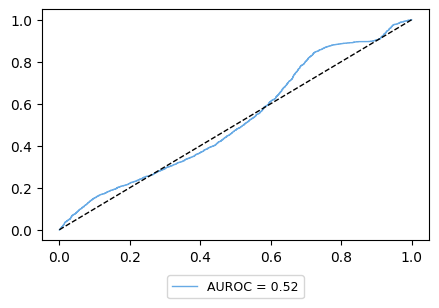

In [9]:
from dev.notebooks.plotting import (
    plot_true_false_distribution, plot_true_false_boxplots, plot_true_false_scores_by_tf_boxplots,
    plot_true_false_scores_by_tf_barplots, plot_auroc
)


fig = plot_auroc(tf_tg_pred, score_col="score")
fig.show()

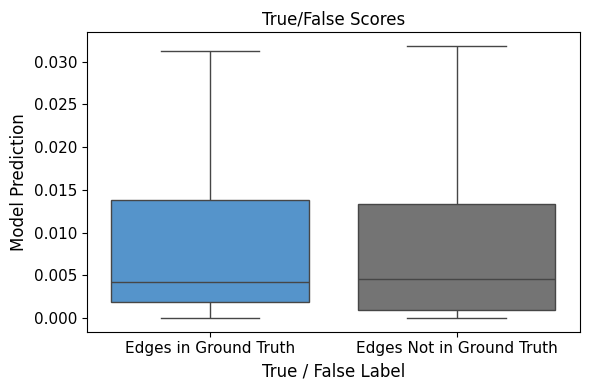

In [10]:
fig = plot_true_false_boxplots(
    df=tf_tg_pred,
    score_col="score",
    xlabel="True / False Label",
    ylabel = "Model Prediction"
    )

In [18]:
import importlib
import dev.notebooks.plotting
importlib.reload(dev.notebooks.plotting)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

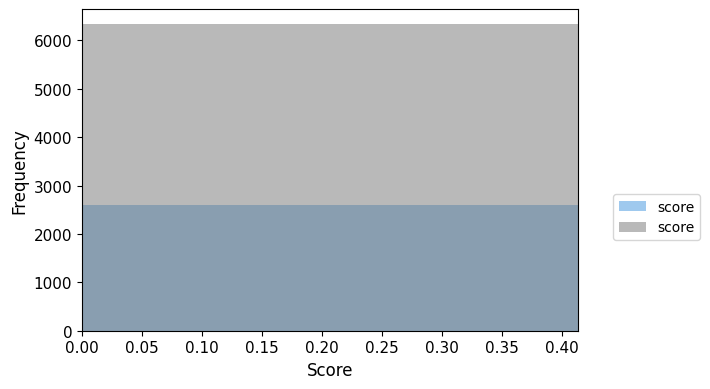

In [19]:
fig = plot_true_false_distribution(
    true_series=tf_tg_pred[tf_tg_pred["label"] == 1]["score"],
    false_series=tf_tg_pred[tf_tg_pred["label"] == 0]["score"],
    
    )